# MultiLayer Perceptron

## 1. Libraries
*Installing and importing necessary packages*

*Working with **Python 3.6** and **PyTorch 1.0.1** *

In [0]:
import sys
import os
# !{sys.executable} -m pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
# !{sys.executable} -m pip install torch torchvision matplotlib
!{sys.executable} -m pip install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!{sys.executable} -m pip install torchvision matplotlib

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer

print("PyTorch version: {}".format(torch.__version__))
cudnn_enabled = torch.backends.cudnn.enabled
print("CuDNN enabled" if cudnn_enabled else "CuDNN disabled")

## 2. Variables
*Indicate the root directory where the data must be downloaded, the directory where the results should be saved and the type of RNN (conventional, LSTM, GRU) and its respective hyper-parameters*

In [0]:
# Make reproducible run
torch.manual_seed(1)

# Settable parameters
params = {'root': './data/',
          'results_dir': './results/',
          'hidden_size': [1024, 2048],
          'input_size': 784,  # MNIST data input (img shape: 28*28)
          'lr': 1e-3,
          'weight_decay': 1e-10, # 5e-4,  # 1e-10,
          'momentum': 0.9,
          'num_classes': 10,  # class 0-9
          'batch_size': 128,
          'optim_type': 'Adam',  # Options = [Adam, SGD, RMSprop]
          'criterion_type': 'CrossEntropyLoss', # Options = [L1Loss, SmoothL1Loss, NLLLoss, CrossEntropyLoss]
          'epochs': 15,
          'save_step': 200,
          'use_cuda': True,
         }

# GPU usage
print("GPU: {}, number: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
device = torch.device('cuda') if params['use_cuda'] and torch.cuda.is_available() else torch.device('cpu')

# Ensure results directory exists
if not os.path.exists(params['results_dir']):
    os.mkdir(params['results_dir'])

GPU: True, number: 1


## 3. Dataset

*Normalizing between (0.1307, 0.3081): global mean and standard deviation of the MNIST dataset*

In [0]:
# Get train and test datasets
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# trans = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(
    root=params['root'],  # directory where the data is or where it will be saved
    train=True,  # train dataset
    download=True,  # download if you don't have it
    transform=trans)  # converts PIL.image or np.ndarray to torch.FloatTensor of shape (C, H, W) and normalizes from (0.0, 1.0)
mnist_test = datasets.MNIST(root=params['root'], train=False, download=True, transform=trans)  # transforms.ToTensor()
print("MNIST Train {}, Test {}".format(len(mnist_train), len(mnist_test)))

# Dataloader: mini-batch during training
mnist_train_dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=params['batch_size'], shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=params['batch_size'], shuffle=True)

MNIST Train 60000, Test 10000


*Dataset examples*

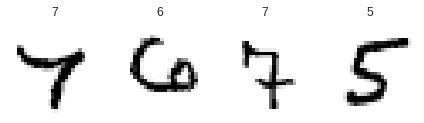

In [0]:
# Plot examples
examples = enumerate(mnist_test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(nrows=1, ncols=4)
for i, ax in enumerate(axes.flat):
  ax.imshow(example_data[i][0]) 
  ax.set_title('{}'.format(example_targets[i]))
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()

## 4. The Model: MLP
$y_t = \sigma(W x_t)$

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_size = params['input_size']
        self.hidden_size = params['hidden_size']
        self.mlp = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size[0]),
            nn.Linear(self.hidden_size[0], self.hidden_size[1]),
            nn.Linear(self.hidden_size[1], params['num_classes'])
        )
        self.softmax = nn.LogSoftmax()  # nn.ReLU()  # nn.LogSoftmax()  # Softmax()
        
    def forward(self, x):           
        out = self.mlp(x)
        out = self.softmax(out)
        return out

*Instantiate model and optimizer*

In [0]:
# Instantiate model
model = MLP()

# Transfer model to device (CPU or GPU according to your preference and what's available)
model = model.to(device)

# Loss criterion
if 'CrossEntropyLoss' in params['criterion_type']:
  criterion = nn.CrossEntropyLoss()
elif 'L1Loss' in params['criterion_type']:
  criterion = nn.L1Loss()
elif 'SmoothL1Loss' in params['criterion_type']:
  criterion = nn.SmoothL1Loss()
else:  # NLLLoss
  criterion = nn.NLLLoss()  

# Optimizer
if 'Adam' in params['optim_type']:
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
elif 'SGD' in params['optim_type']:
  optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'], momentum=params['momentum'])
elif 'RMSprop' in params['optim_type']:
  optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'], momentum=params['momentum'])

# New results dir based on model's parameters
res_dir = params['results_dir'] + 'mlp_{}_{}_lr{}_weight{}_trainSize_{}_testSize_{}/'.\
    format(params['criterion_type'], params['optim_type'], params['lr'], params['weight_decay'], len(mnist_train), len(mnist_test))

if not os.path.exists(res_dir):
    os.mkdir(res_dir)

print("res_dir: {}".format(res_dir))
log_file = open(res_dir + 'log.txt', 'w')

res_dir: ./results/mlp_CrossEntropyLoss_Adam_lr0.001_weight1e-10_trainSize_60000_testSize_10000/


## 5. Train

In [0]:
start_timer = timer()

loss_arr = []
train_acc_arr = []
first_time = True
total_num_steps = len(mnist_train_dataloader)

# model.train()
model.zero_grad()
optimizer.zero_grad()
for e in range(1, params['epochs']+1):
    for i, (img, label) in enumerate(mnist_train_dataloader):
        img = Variable(torch.squeeze(img)).to(device)
        img = img.view(-1, params['input_size'])
        label = Variable(label).to(device)
        
        # Forward
        out = model(img)
        loss = criterion(out, label)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_arr.append(loss.item())
        
        if i % params['save_step'] == 0:
            # Train Accuracy
            _, predicted = torch.max(out.data, 1)
            total = label.size(0)
            correct = (predicted == label).sum().item()
            acc = 100 * correct / total
            train_acc_arr.append(acc)
            # Print update
            perc = 100 * ((e-1)*total_num_steps + (i+1))/float(params['epochs'] * total_num_steps)
            str_res = "Completed {:.2f}%: Epoch/step [{}/{} - {}/{}], loss {:.4f}, acc {:.2f}, best acc {:.2f}".format(perc, e, params['epochs'], i+1, total_num_steps, loss.item(), acc, max(train_acc_arr))
            print(str_res)
            # Save log
            log_file.write(str_res)
            
# Save model checkpoint
torch.save(model.state_dict(), res_dir + 'model.ckpt')
plt.show()
log_file.close()

end_timer = timer() - start_timer
print("Model took {:.4f} mins ({:.4f} hrs) to finish training with best train accuracy of {:.4f}%".format(end_timer/60, end_timer/3600, max(train_acc_arr)))

*Plot training loss curve*

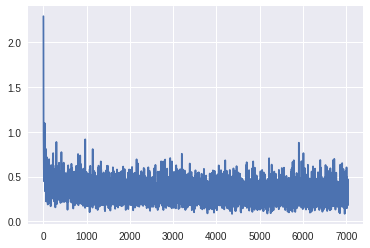

In [0]:
# Save training loss
plt.plot(loss_arr)
# plt.semilogy(range(len(loss_arr)), loss_arr)
plt.savefig(res_dir + 'loss.png')

## 6. Test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Test Accuracy: 90.6600 %
Label: tensor([7, 2, 6, 2, 7, 1, 3, 0, 8, 6, 3, 0, 4, 7, 7, 9], device='cuda:0')
Predicted: tensor([7, 2, 6, 2, 7, 1, 3, 0, 8, 5, 5, 0, 4, 7, 7, 9], device='cuda:0')


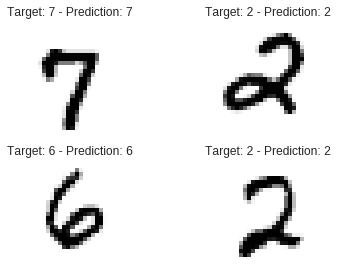

In [0]:
# Testing doesn't require the use of gradients since weights aren't being updated
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for img, label in mnist_test_dataloader:
        img = torch.squeeze(img).to(device)
        img = img.view(-1, params['input_size'])
        label = label.to(device)
        
        # Forward
        out = model(img)
        
        # Test
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    # Accuracy
    print('Test Accuracy: {:.4f} %'.format(100 * correct / total)) 

    # Show 4 test images
    fig, axes = plt.subplots(nrows=2, ncols=2)
    img_cpu = img.cpu()
    label_cpu = label.cpu()
    print("Label: {}".format(label))
    print("Predicted: {}".format(predicted))
    for i, ax in enumerate(axes.flat):
      img_cpu_i = img_cpu[i]
      img_cpu_i = img_cpu_i.view(28, 28)
      ax.imshow(img_cpu_i) 
      ax.set_title('Target: {} - Prediction: {}'.format(label_cpu[i], predicted[i]))
      ax.set_xticks([])
      ax.set_yticks([])
    plt.tight_layout()